In [1]:
import cv2 as cv
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import re

# Define Classes

In [2]:
class_names = [
    "0",
    "1",
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
    "9",
    "+",
    ".",
    "/",
    "=",
    "*",
    "-",
    "X",
    "Y",
    "Z",
]

# Load Model

In [3]:

model = tf.keras.models.load_model("../models/19_class.h5")

lite = tf.lite.Interpreter(model_path = '../models/tflite_quant_model.tflite')
input_details = lite.get_input_details()
output_details = lite.get_output_details()
lite.resize_tensor_input(input_details[0]['index'], (1, 100, 100,3))
lite.resize_tensor_input(output_details[0]['index'],(1,19))
lite.allocate_tensors()

2022-04-12 04:34:03.872694: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
def show_prediction_lite(image):
    image = np.expand_dims(image, axis=0)
    image = image.astype('float32')/255
    lite.set_tensor(input_details[0]['index'], image)
    lite.invoke()
    predictions = lite.get_tensor(output_details[0]['index'])
    label = class_names[np.argmax(predictions)]
    confidence = np.max(predictions)*100
    confidence = str(confidence)[:2]
    return label,confidence
    

# Helper Function

In [6]:
def show_img(img):
    plt.imshow(img, cmap='gray', vmin = 0, vmax = 255)
    
    
def show_images(images, title=''):
    plt.figure(figsize=(15, 15))
    for i, image in enumerate(images):
        plt.subplot(4,4,i+1)
        plt.imshow(image)
        plt.title(title)
    
    
def show_prediction(image):
    image = np.expand_dims(image, axis=0)
    image = image.astype('float32')/255
    predictions = model.predict(image)
    label = class_names[np.argmax(predictions)]
    confidence = np.max(predictions)*100
    confidence = str(confidence)[:2]
    
    return label,confidence


def extra_padding(img, padding=50):
    return cv.copyMakeBorder(img, top=padding, bottom=padding, left=padding, right=padding, borderType=cv.BORDER_CONSTANT, value=(255,255,255))

(602, 602, 3)


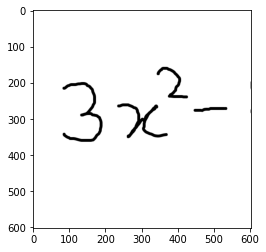

In [44]:
img_path = './image.png'
image = cv.imread(img_path,cv.IMREAD_UNCHANGED)
try:
    alpha = image[:,:,3]
    alpha = cv.bitwise_not(alpha)
    new_image = cv.merge([alpha,alpha,alpha])
    image = new_image
except:
    pass
finally:
    print(image.shape)
    show_img(image)


# Do some preprocessing

In [45]:
def get_contour(image):
    gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    edged = cv.adaptiveThreshold(gray, 255, cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY_INV, 11, 4)
    (contours, _) = cv.findContours(edged, cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
    return contours
    
contours = get_contour(image)

# Find Bounding box using Contours 

In [46]:
def get_bounding_box(contours):
    chars_bb = []
    for contour in contours:
                contour = contour.reshape((contour.shape[0],contour.shape[2]))
                left_tc = np.amin(contour, axis=0)
                right_bc = np.amax(contour, axis=0)
                min_x = left_tc[0]
                max_x = right_bc[0]
                min_y = left_tc[1]
                max_y = right_bc[1]
                chars_bb.append([min_x,min_y,max_x,max_y])
    return chars_bb


chars_bb = get_bounding_box(contours)

# Show bounding box

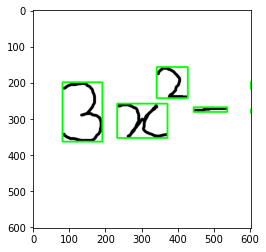

In [47]:
copy = image.copy()
for box in chars_bb:
    cv.rectangle(copy, (box[0], box[1]), (box[2],box[3]),(0,255,0),3)
    
show_img(copy)

# Replacing Double Minus as EqualsTo

Note even though this logic should repalce most double minus with
equals to we still need further logic to explicitly convert two 
consecutive minus as equals

In [36]:
def remove_equals(chars_bb):    
    chars_bb.sort()
    for i, box in enumerate(chars_bb):
        try:
            next_box = chars_bb[i+1]
        except IndexError:
            break
    
        if abs(box[0] - next_box[0]) <= 30:
            min_x = min(box[0],next_box[0])
            min_y = min(box[1],next_box[1])
            max_x = max(box[2],next_box[2])
            max_y = max(box[3],next_box[3])
            new_box = [min_x,min_y,max_x,max_y]
            chars_bb[i] = new_box
            chars_bb.remove(next_box)
    return chars_bb 
        
chars_bb = remove_equals(chars_bb)        

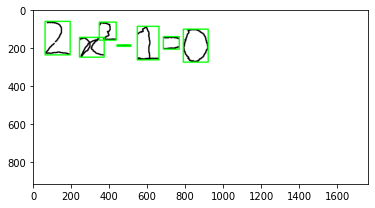

In [37]:
copy = image.copy()
for box in chars_bb:
    cv.rectangle(copy, (box[0], box[1]), (box[2],box[3]),(0,255,0),5)
    
show_img(copy)

# Crop the Images

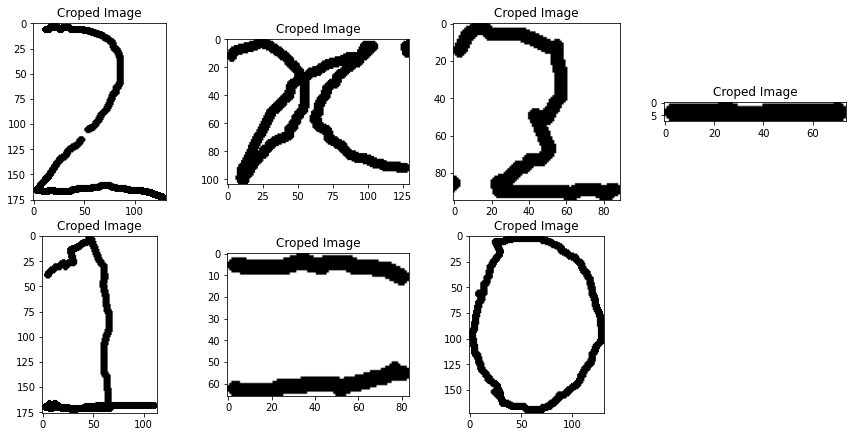

In [38]:
def get_cropped_images(image,chars_bb):
    croped_images = []
    copy = image.copy()
    for box in chars_bb:
        x_min = box[0]
        y_min = box[1]
        height = abs(box[0]-box[2])
        width = abs(box[1]-box[3])
        character = copy[y_min:y_min+width , x_min:x_min+height]
        croped_images.append(character)
    return croped_images    
    
croped_images = get_cropped_images(image,chars_bb)
show_images(croped_images, title='Croped Image')

# Paddding the images
Images need to be padded for the model to work

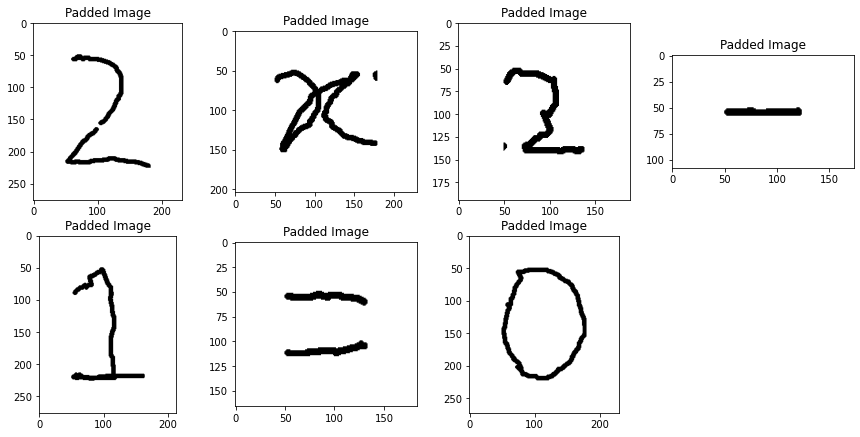

In [39]:
def get_padded_images(croped_images):
    padded_images = []
    for img in croped_images:
        padded_img = extra_padding(img)
        padded_images.append(padded_img)
    return padded_images    

padded_images = get_padded_images(croped_images)
show_images(padded_images, title='Padded Image')

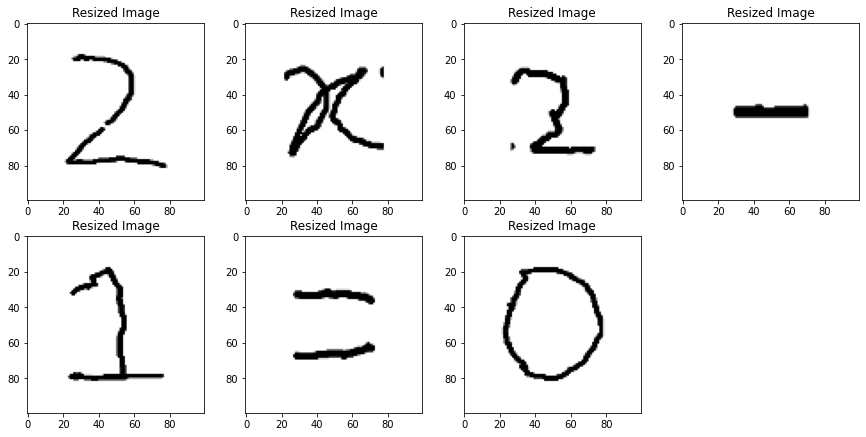

In [40]:
def get_resized_images(padded_images):
    resized_images = []
    for img in padded_images:
        resized_img = cv.resize(img, (100, 100), interpolation=cv.INTER_LINEAR)
        resized_images.append(resized_img)
    return resized_images

resized_images = get_resized_images(padded_images)
show_images(resized_images, title='Resized Image')

# Identify the image type
Subscript or Base

In [41]:
def get_centroid(chars_bb):
   centroids = []
   for _, box in enumerate(chars_bb):
      centroidX, centroidY = (int((box[0]+box[2])/2),int((box[1]+box[3])/2))
      centroids.append((centroidX,centroidY))
   return centroids

def classify_superscript(centroids, chars_bb):
    is_super = ['base' for _ in range(len(chars_bb))]
    for i, box in enumerate(chars_bb):
        try:
            next_box = chars_bb[i+1]
        except IndexError:
            is_super.append('base')
            return is_super
        
        bb1_y1 = box[1]
        bb2_y2 = next_box[3]
        cb1y = centroids[i][1]
        cb2y = centroids[i+1][1]
       
        if bb1_y1 > cb2y and cb1y > bb2_y2:
            is_super[i+1] = 'super' 

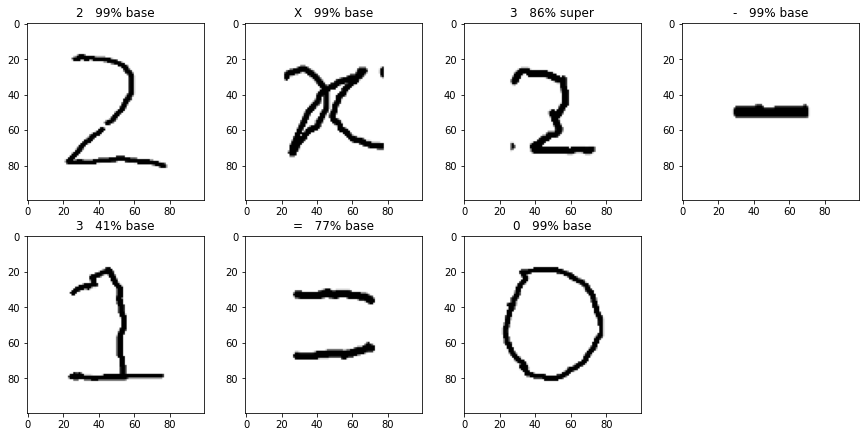

In [42]:
centroids = get_centroid(chars_bb)
is_super = classify_superscript(centroids,chars_bb)
plt.figure(figsize=(15, 15))
for i, img in enumerate(resized_images):
    label, conf = show_prediction_lite(img)
    plt.subplot(4,4,i+1)
    plt.imshow(img)
    title = label+'   '+ conf + '% ' + is_super[i]
    plt.title(title)
   

In [43]:

def build_poly_equation(images, types):
    '''
    Input: Image of polynomial equation
    Output:Equation as a string
    '''
    eqn = ''
    for (image,char_type) in zip(images,types):
        label, conf = show_prediction(image)
        if char_type == 'super':eqn += '^' + label
        else:eqn += label
    return eqn

def add_leading_ones(eqn):
    '''
    This function takes add leading 1 to x
    Input: +x^3+x^2+x
    Output: +1x^3+1x^2+1x
    '''
    position_table = {}
    count = 0

    for i, char in enumerate(eqn):
        if char in ['x','X'] and eqn[i-1] in ['+','-']:
            count += 1
            position_table[count] = i
            
    for key,value in position_table.items():
        eqn = eqn[:value+key-1] + '1' + eqn[value+key-1:]
    
    return eqn
   

def standardize_eqn(eqn):
    '''
    Standardizes an equation by removing = and shift's lone coeff to left
    and adds ^1 to the end of last term
    :param eqn: equation in the form of ax^b+cx^d+...+ex
    :return: equation in the form of ax^b+cx^d+...+ex^1
    :param equation: equation to standardize eg 2x^2+3x=7
    :return: standardized equation eg 2x^2+3x-7
    '''
        
    # Add a ^1 to the end of the last x
    for i, char in enumerate(eqn):
        if char in ['x','X'] and eqn[i+1] != '^':
            eqn = eqn[:i+1] + '^1' + eqn[i+1:]
    
    # Add a leading + at very beginning
    if eqn[0] != '-':
        eqn = '+'+eqn
    
    # add a leading 1 where necessary
    eqn = add_leading_ones(eqn)
    
    # remove = sign
    try:
        left, right = eqn.split('=')[0], eqn.split('=')[1]
    except IndexError:
        return eqn
    
    if right == '': return left
    elif right == '0': return left
    else:
        coeff = str(-1*float(right))
        if coeff[0] != '-': coeff = '+'+coeff
        eqn = left +   coeff 
        return eqn

def get_sorted_eqn(eqn):
    '''
    This function takes a unsorted polynomial equation and returns a sorted polynomial equation
    Note: If the sign of first term is postive, then it must be specified as +
    Eg: '2x+3=0' should be given as '+2x+3=0'
    '''
     # get the constant in the eqn
    try:
        number = re.findall(r'[+,-]\d\.\d$|[+,-]\d$', eqn)[0]
    except IndexError:
        number = ''
    # get all the terms in the equation
    terms = re.findall(r'[+,-]\d[x,X]\^\d|[+,-]\d\.\d[x,X]\^\d', eqn)
    #save the sign of the term in dictinary
    signs = {term[1:]: term[0] for term in terms}
    # remove first character from each term
    terms = [term[1:] for term in terms]
    #reverse the terms so power sorting is based on power
    terms = [term[::-1] for term in terms]
    #sort terms alphabetically
    terms = sorted(terms, reverse=True)
    #undo the reversing
    terms = [term[::-1] for term in terms]
    #now add the signs back to terms
    terms = [signs[term] + term for term in terms]
    sorted_eqn = ''.join(terms) + number
    return sorted_eqn   

def get_visible_coeff(eqn):
    '''
    This function returns the coefficient of x in the equation
    The equation should be in the form of ax^b+cx^d+...+ex
    Notice that the last term need not contain '^' 
    Eg. 5x will be treated as 5x^1 
    The equation cannot contain '=' sign
    This function will not work for zero coefficients
    '''
  
    #remove all powers
    no_carets = re.sub(r"(\^\d+)", "", eqn)
    # get numeric coefficients
    raw_coeffs = re.findall(r'[\d\.\-\+]+', no_carets)
    # add a 1 to lone signs and convert coefficients to float
    coeffs = [float(x) for x in raw_coeffs] 
    return coeffs

def get_powers(eqn):
    '''
    Returns all powers from eqn
    Eg: '2x^2+3x^2' will return [2,2]
    '''
    powers = []
    for x in re.findall(r'(\^\d+)', eqn):
        powers.append(int(x[1:]))
    return powers

def get_all_coeffs(eqn):
    '''
    Input: Polynomial equation in the form of ax^b+cx^d+...+ex
    Output: List of all coefficients (Even if they are zero)
    '''
    coeffs = get_visible_coeff(eqn)
    powers = get_powers(eqn)
    degree = max(powers)
    
    for i in range(degree,0,-1):
        if i not in powers:
            coeffs.insert((degree-i),0.0)
    return coeffs


def build_poly_equation(equation):
    standardized_eqn = standardize_eqn(equation)
    sorted_eqn = get_sorted_eqn(standardized_eqn)
    coefficents = get_all_coeffs(sorted_eqn)
    solutuion = np.roots(coefficents)
    soln_type = 'real' if np.isreal(solutuion).all() else 'complex'
    return solutuion, soln_type



# Solving the equation

Combining all the above steps together

In [ ]:
img_path = '../test_cases/poly_eqn.png'
image = cv.imread(img_path)
contours = get_contour(image)
chars_bb = get_bounding_box(contours)
chars_bb = remove_equals(chars_bb)   
croped_images = get_cropped_images(image,chars_bb)
padded_images = get_padded_images(croped_images)
resized_images = get_resized_images(padded_images)
centroids = get_centroid(chars_bb)
chars_type = classify_superscript(centroids,chars_bb)
equation = build_poly_equation(resized_images,chars_type)